In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

{}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!mkdir "/content/data"

In [ ]:
cd "/content/data/"

/content/data


In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

 97% 414M/427M [00:02<00:00, 177MB/s]
100% 427M/427M [00:02<00:00, 175MB/s]


In [ ]:
!unzip "/content/data/waste-classification-data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

In [ ]:
!rm "/content/data/waste-classification-data.zip"

In [ ]:
# Import libraries

from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.python.keras.engine
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [ ]:
train="/content/data/DATASET/TRAIN"
test="/content/data/DATASET/TEST"

In [ ]:
def load_dataset(path):
    data = load_files(path) #load all files from the path
    files = np.array(data['filenames']) #get the file  
    targets = np.array(data['target'])#get the the classification labels as integer index
    target_labels = np.array(data['target_names'])#get the the classification labels 
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train)
x_test, y_test,_ = load_dataset(test)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)

In [ ]:

def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC) #As images have different size, resizing all images to have same shape of image array
        images_as_array[idx] = res
    return images_as_array

In [ ]:
x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Training set shape :  (18051, 100, 100, 3)
Validation set shape :  (4513, 100, 100, 3)
Test set shape :  (2513, 100, 100, 3)


In [ ]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
from glob import glob 

className = glob(train + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255) 
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train, 
        target_size= (224,224),
        batch_size = 256,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test, 
        target_size= (224,224),
        batch_size = 256,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
x_train.shape

(18051, 100, 100, 3)

In [ ]:
# Convolutional Neural Network - CNN 

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.3))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"]) 
batch_size = 256 

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=15,
        validation_data = test_generator) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/15
89/89 [==============================] - 75s 828ms/step - loss: 0.5571 - accuracy: 0.7776 - val_loss: 0.3375 - val_accuracy: 0.8798
Epoch 2/15
89/89 [==============================] - 73s 820ms/step - loss: 0.3982 - accuracy: 0.8329 - val_loss: 0.3523 - val_accuracy: 0.8747
Epoch 3/15
89/89 [==============================] - 73s 819ms/step - loss: 0.3712 - accuracy: 0.8458 - val_loss: 0.3222 - val_accuracy: 0.8703
Epoch 4/15
89/89 [==============================] - 74s 822ms/step - loss: 0.3409 - accuracy: 0.8596 - val_loss: 0.3081 - val_accuracy: 0.8814
Epoch 5/15
89/89 [==============================] - 74s 823ms/step - loss: 0.3144 - accuracy: 0.8727 - val_loss: 0.2684 - val_accuracy: 0.9001
Epoch 6/15
89/89 [==============================] - 74s 822ms/step - loss: 0.2894 - accuracy: 0.8840 - val_loss: 0.3008 - val_accuracy: 0.8882
Epoch 7/15
89/89 [==============================] - 74s 822ms/step - loss: 0.2511 - accuracy: 0.8994 - val_loss: 0.2734 - val_accuracy: 0.9025

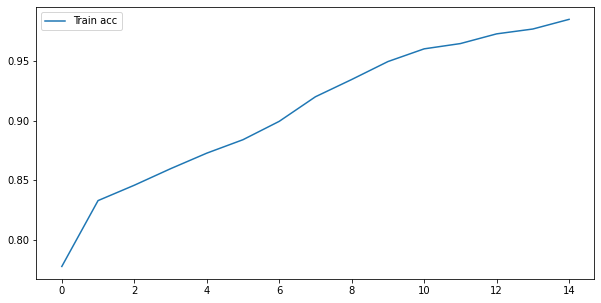

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.legend()
plt.show()

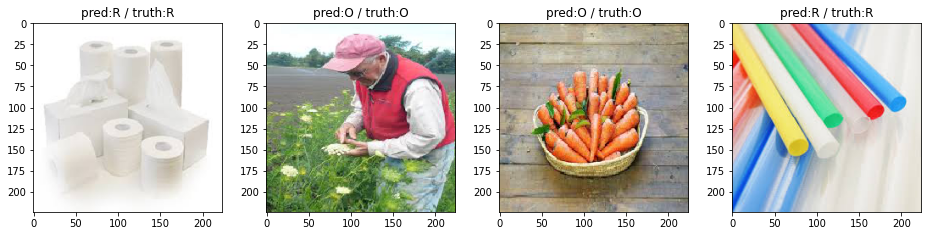

In [ ]:
test_x, test_y = test_generator.__getitem__(1)

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = model.predict(test_x)
preds
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
